In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import scipy.optimize
import scipy.ndimage
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import combinations
from scipy.interpolate import griddata
# %matplotlib notebook

In [2]:
#using some custom arrays to observe/display clearly the effects of functions/methods
# - 1x class: "zygomap(filename=None, array=None, map1=None, map2=None, angle=None)"
# - 2(+)x functions to work with pairs of maps:
# - - - "combinemaps(lowermap,uppermap,optimised=True,output=True)" - lowermap,uppermap are zygomap objects
# --------- combinemaps uses ztestf() so this is also a distinct function, while testf() (for flattening) can be a class method
# --------- could be defined within combinemaps (?) as it's only used there
# - - - "matchdims(map1,map2)" - map1,map2 are MxN arrays (used from within combinemaps(), using map.heights array)
# - - - (possible addition) - to simulate realistic contacts of surfaces when combined (e.g. find 3 points) (would be used by combinemaps())
# - - - "comparebonds" - to simulate interface (bond) of each combination of available maps, display lowest PV & RMS heights
# - - - "rotatepoints" - general rotation function made, but has no real use for zygomaps as each rotation method has unique needs

In [3]:
class zygomap:
    
    def zygoread(self, filename):
        #works with specific ASCII format .txt files (documented in MetroPro reference guide)
        with open(filename, "r") as f:
            fstrings = f.read().split("\"")  # - split by qoutation marks (easier to seperate string fields from data)

            fields = []
            data = []
            section = 0
            for elt in fstrings:
                if "#" in elt:  # - use this test to show end of header section, then switch to next section
                    section += 1
                    pass

                if section == 0:  # - processing header section
                    #multiple fields are stored within single strings, so need to split by newline to narrow down
                    #numbers stored within strings can be extracted afterwards
                    #excess artifacts can be filtered out using if (True) test on elements of split string
                    #fails on empty string, thus keeping only the relevant fields
                    elt = elt.split("\n")
                    values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                    #test for non-empty lists (indicates no data was found in values list)
                    if values:
                        fields.append(values)

                elif section == 1:  # - move to data extraction for intensities and phases
                    #the initial split left the both datasets in a single string - separate by "#"
                    #split string containing a dataset then iterate through the resulting lines of 10
                    #append all values to a 'data' array, filter as before
                    #splitting by "#" will result in 2 lists stored in the overall 'data' list
                    #i.e. can extract: intensities = data[0], phases = data[1]
                    for line in elt.split("#"):
                        values = [_ for _ in line.split() if _]
                        if values:
                            data.append(values)
                        
        return fields, data
    
    def crop(self, radius=0):
        #allow user to crop to extract only data within some radius
        #most needed to avoid large edge effects (discontinuities)
        #use the (stored) centred x and y positions to check against radius
        #make a new cropped array where points outwith radius are set to nan
        #and "zoom in" to store only the array rows & columns within the valid range
        #will run during __init__(), with default radius = 0, so can avoid editing if radius is default
        #and only do if user chose a (non-zero) radius
        #thus only the centring of view by array slicing is performed (no need for separate functions)
        
        #set cropped array based on original state of heights (so not cropping multiple times and losing data)
#         cropped = self.heights0.copy()
        cropped = self.heights1.copy()
        
        if radius != 0:
            #if radius non-zero, we will be setting valid points to invalid (nan)
            #use centred x,y grid points for full data array to make a mask for points outside radius
            #then just change these points to nan (thus matching the pre-existing background)
            outsideR = self.x**2 + self.y**2 > radius**2
            cropped[outsideR] = np.nan
            
            #could add a flag/callback here to automatically re-apply rotations after crops (otherwise advise user to do it)
            #e.g. if callback = True -> rotateflat()
        
        #now find the extreme bounds of valid points and slice the array to show only the data within
        validrows, validcols = np.where(np.isfinite(cropped))
        lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
        
        
        cropped = cropped[upp:low+1, lft:rgt+1]
        self.heights = cropped.copy()
        
        #update valid positions, after rows/columns removed
        self.validrows, self.validcols = np.where(np.isfinite(self.heights))
        self.centre = int(np.nanmean(self.validcols)),int(np.nanmean(self.validrows))
        
        return cropped
    
    def testf(self, *args):
        #test function to be minimised by optimisation algorithm
        #uses rotations around x & y axes to minimise peak-to-valley height of map
        angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
        array = args[1]  # - the simple 2D array of height values

        dims = array.shape
        x,y = np.indices(dims)  # - use row,column positions (i.e. matrix i,j) as the x,y for the position vectors
        
        #make array of position vectors in NxMx3 format: i.e. [x,y,height] as a single element for one point in 3D
        #use dstack to arrange the separate array values down each column, then reshape to (NxM)x3 array
        x -= self.centre[0]  # - to ensure rotations around centre (add back after rotating)
        y -= self.centre[1]
        centreOffset = array[self.centre[0],self.centre[1]]  # - remove offset of centre height (makes centre the origin)
        array -= centreOffset
        
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(vectarray.size//3, 3)

        #define rotations around x and y axes respectively and combine via * operation
        rx = Rot.from_rotvec(angx*np.array([1,0,0]))
        ry = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rx*ry

        #apply overall rotation to entire vector array (rotates each vector individually)
        #using rounding of the new x,y (the row,column values) to approximate positions to grid
        #NOTE: actually not necessary to recreate grid for testf
        # - only have to calculate peakvalley here, and can do that just from the new z's (newarray[:,2])
        newarray = r.apply(vectarray)
#         newarray[:,0] = np.round(newarray[:,0])
#         newarray[:,1] = np.round(newarray[:,1])
        #retain only the x,y inside the original grid shape (otherwise have to extend to arbitrary rows/columns)
#         newarray = newarray[(newarray[:,0] < dims[0]) & (newarray[:,1] < dims[1])]
        
        #create "empty" array of nan, matching original grid
        #then set values directly by using integer conversion of x,y columns
#         newheights = np.ones(dims) * np.nan
#         newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
#         newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method

        #check the peak to valley height of rotated array
        #note: may use a best-fit plane to the array (e.g. reducing sum of squared deviations across entire array)
        #would potentially not need a test function for this (?) as the minimisation would be done by fitting algorithm
        peakvalley = np.nanmax(newarray[:,2]) - np.nanmin(newarray[:,2])

        return peakvalley
    
    def rotateflat(self, array=None):
        #apply minimization of peak-to-valley height for rotations around x & y axes
        #call to external testf() (or make testf internal ?)
        #then apply best rotation and return rotated array
        #"array" argument left so normal or cropped maps can be used (i.e. self.heights vs self.cropped)
        #detect array=None to mean default self.heights
        if array is None:
            array = self.heights
        
        #minimise peak to valley height for rotation angles around x-axis and y-axis
        #x0 gives the initial "guess" for the optimiser to use as x & y angles within testf()
        opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
        params = scipy.optimize.minimize(self.testf, x0=[0,0], args=array, tol=1e-15, method="Nelder-Mead", options=opts)
        angx,angy = params["x"]  # - access the optimal angles found by the minimisation
        
        
        #now apply the optimal rotations (same method as contained in test function, "testf")
        dims = array.shape
        x,y = np.indices(dims)
        x -= self.centre[0]  # - to ensure rotations around centre (add back after rotating)
        y -= self.centre[1]
        centreOffset = 0  # - remove offset of centre height (makes centre the origin)
        if np.isfinite(array[self.centre[0],self.centre[1]]):
            centreOffset = array[self.centre[0],self.centre[1]]
#             print(1, centreOffset)
        
        #create array stack of vectors (MxNx3)
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)  # - reshape to (MxN)x3
        
        #define rotations along x & y axes with the specified angles, combine with * operation
        rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
        roty = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rotx*roty
        
        newarray = r.apply(vectarray)
        #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
        #approximate new x,y positions by rounding to the original grid (integers)
        newarray[:,0] = np.round(newarray[:,0]) + self.centre[0]
        newarray[:,1] = np.round(newarray[:,1]) + self.centre[1]
        newarray[:,2] += centreOffset
        #extract only the x,y inside the original grid shape (otherwise have to extend grid to handle arbitrary x,y values)
        #but should use the full array of rotated vectors to give accurate calculations
        newvalid = newarray[(newarray[:,0] >= 0) & (newarray[:,0] < dims[0]) & (newarray[:,1] >= 0) & (newarray[:,1] < dims[1])]
        
        #create "empty" nan array, matching original dimensions
        #then directly set values using integer conversion of x,y columns
        newheights = np.ones(dims) * np.nan
        newheights[newvalid[:,0].astype("int"), newvalid[:,1].astype("int")] = newvalid[:,2]
        
        #centre in z-axis
        newheights -= np.nanmean(newheights)
        
        #debug
#         print(newvalid)
        
        #generate attributes for flattened map (should probably set these before this point)
        #i.e. in __init__() for initial array (in case of problems they would then still be defined in some way)
        self.peak, self.valley = np.nanmax(newarray[:,2]), np.nanmin(newarray[:,2]) # - need to consider all rotated values, even if they are not going to be stored (outwith bounds)
        self.peakvalley = self.peak - self.valley
        self.rms = np.sqrt(np.nanmean(newarray[:,2]**2))
        
        #update the stored heights array
        self.heights = newheights.copy()
        
        return newheights
    
    #use __str__ method to provide user summary on calling print(zygomap)
    #three possible paths, depending if single file object; interface created of two maps; or simply a user-defined array
    def __str__(self):
        if hasattr(self, "filename"):
            return "zygomap object for file: {0}. \nPeak-to-valley height: {1:.1f} nm \nRMS height: {2:.1f} nm".format(repr(self.filename), self.peakvalley*1e9, self.rms*1e9)
        elif all(hasattr(self, attr) for attr in ("map1","map2","angle")):
            return "zygomap interface object for {0} & {1} combined at angle {2:.0f} degrees. \nPeak-to-valley height of bond: {3:.4e} m \nRMS height of bond: {4:.4e} m".format(repr(self.map1), repr(self.map2), self.angle, self.peakvalley, self.rms)
        else:
            return "zygomap object for user-provided array. \nPeak-to-valley height: {0:.4e} m \nRMS height: {1:.4e} m".format(self.peakvalley,self.rms)
    
    def __init__(self, filename=None, array=None, map1=None, map2=None, angle=None, flatten=True):
        #initialise zygomap object, process to remove tilts and store information about surface and/or from file header
        #2 ways to make zygomap object:
        # - 1) reading in header and data arrays from ASCII .txt file (MetroPro formatting - see reference guide)
        # - -  defines a map for a single component, as specified by file (use "filename" keyword)
        # - 2) supplying an array directly to be processed (using "array" keyword)
        # - -  particularly needed to store the interface map for combinations of other maps and their optimal angle
        # - -  also allows simple user-defined MxN arrays to be provided
        if filename is not None:
            self.filename = filename
            #get header and data from file by user-defined function "zygoread" (change to class method ?)
            fields, data = self.zygoread(filename)

            #header extraction
            self.stringConstant = fields[0][0]
            chunk = fields[0][1].split()
            self.softwareType, self.majorVersion, self.minorVersion, self.bugVers = [int(n) for n in chunk]

            self.softwareDate = fields[1][0]

            chunk = fields[2][0].split()
            self.intensOriginX, self.intensOriginY, self.intensWidth, self.intensHeight, self.Nbuckets, self.intensRange = [int(n) for n in chunk]

            chunk = fields[2][1].split()
            self.phaseOriginX, self.phaseOriginY, self.phaseWidth, self.phaseHeight = [int(n) for n in chunk]

            self.comment = fields[3][0]

            self.partSerNum = fields[4][0]
            self.partNum = fields[5][0]

            chunk = fields[6][0].split()
            self.source = int(chunk.pop(0))  # - want 1st and last separately (they are int, rest are float)
            self.timeStamp = int(chunk.pop(-1))  # - use .pop(index) to separate the item from the list
            self.intfScaleFactor, self.wavelengthIn, self.numericAperture, self.obliquityFactor, self.magnification, self.cameraRes = [float(n) for n in chunk]

            chunk = fields[6][1].split()
            self.cameraWidth, self.cameraHeight, self.systemType, self.systemBoard, self.systemSerial, self.instrumentId = [int(n) for n in chunk]

            self.objectiveName = fields[7][0]

            #want both index 6 & 7 seperately, as they need to be floats
            #convert the rest to int as before
            chunk = fields[8][0].split()  # - looks messier but should use this throughout to reduce repeated splitting
            self.targetRange = float(chunk.pop(6))  # - remove item at index 6 and returns it (and modifies original list)
            self.lightLevel = float(chunk.pop(6))  # - do it again as the index 7 is now at index 6 in the modified list
            self.acquireMode, self.intensAvgs, self.PZTCal, self.PZTGain, self.PZTGainTolerance, self.AGC, self.minMod, self.minModPts = [int(n) for n in chunk]

            chunk = fields[8][1].split()
            self.disconFilter = float(chunk.pop(4))
            self.phaseRes, self.phaseAvgs, self.minimumAreaSize, self.disconAction, self.connectionOrder, self.removeTiltBias, self.dataSign, self.codeVType = [int(n) for n in chunk]

            self.subtractSysErr = int(fields[8][2])

            self.sysErrFile = fields[9][0]

            chunk = fields[10][0].split()
            self.refractiveIndex, self.partThickness = [float(n) for n in chunk]

            self.zoomDesc = fields[11][0]


            #extract intensity and phase data as numpy arrays (reshape to header parameters)
            self.intensitymap = np.array(data[0], dtype=float).reshape(self.intensHeight, self.intensWidth)
            self.phasemap = np.array(data[1], dtype=float).reshape(self.phaseHeight, self.phaseWidth)

            #handle invalid values (given in MetroPro manual)
            self.intensitymap[self.intensitymap >= 64512] = np.nan
            self.phasemap[self.phasemap >= 2147483640] = np.nan

            #create arrays in terms of number of waves, and height itself (in metres)
            #by given formula
            if self.phaseRes == 0:
                self.R = 4096
            elif self.phaseRes == 1:
                self.R = 32768
                
            #conversion formula from MetroPro manual
            self.waves = self.phasemap*(self.intfScaleFactor*self.obliquityFactor)/self.R
            self.heights = self.waves*self.wavelengthIn
             
        elif array is not None:
            #allow map object to be created from scratch (i.e. make interface as a map object directly)
            
            #set info about interface's source maps and their combination
            #leave default as None, this is only applicable to interfaces created out of combinemaps
            #which provides the 2 filenames and optimised angle
            #test if this is a combination of maps (interface) or user-defined single map ("map1","map2","angle" do not apply)
            if None not in (map1,map2,angle):
                self.map1 = map1
                self.map2 = map2
                self.angle = angle
            self.heights = array.copy()
            
        
        ########################
        ########################
        ##pre-processing maps
        
        #grid points for use in some methods (?) (just using array i,j position index (can scale later))
        self.y, self.x = np.indices(self.heights.shape)
        
        #apply cropping first (user-defined radius ? or default ?)
        #self.cropped = self.crop(self.heights)
        #orderings/logistics of this needs fixed: which array is edited? when? what effect should user cropping give?
        #create a copy of the initial height array, this allows crop to act on those values and provide new self.heights
        #without data loss
        self.heights0 = self.heights.copy()
#         self.cropped = self.heights[:]  # - slice notation actually still links the variables, need np.copy() instead
        #store initial attributes just so they are not missing at any point
        #they will be inaccurate initially (e.g. based on tilted map), but get updated via rotateflat()
        self.peak, self.valley = np.nanmax(self.heights0), np.nanmin(self.heights0)
        self.peakvalley = self.peak - self.valley
        self.rms = np.sqrt(np.nanmean(self.heights0**2))
        
        #adjust to centre of valid points (centre of surface)
        self.validrows, self.validcols = np.where(np.isfinite(self.heights0))
        self.centre = int(np.nanmean(self.validrows)), int(np.nanmean(self.validcols))
        self.x -= self.centre[1]
        self.y -= self.centre[0]
        
                
        #remove tilt if present
        #note: added "flatten" keyword to allow user to use the map as read from file
        #still cropped to centre the view, but without removing any tilt
        #and also make sure to adjust valid rows & columns for this fully flattened array
        #use a 3rd heights array - a flattened but not cropped version
        #so will have: self.heights0 - the original data, self.heights1 - flattened version, self.heights - flattened and cropped to centre on valid area
        self.heights1 = self.heights0.copy()
        if flatten:
            self.heights1 = self.rotateflat(self.heights1)
            self.validrows, self.validcols = np.where(np.isfinite(self.heights1))  # - update the valid points for flattened map
            
            
            self.heights = self.heights1.copy()  # - keep heights1 stored; use heights as main array object for further uses
        
        self.crop()
        
        
        return

In [4]:
def ztestf(*args):  # - optimisation of rotation around z-axis of upper map w.r.t lower map
    angz = args[0][0]  # - optimize.minimize gives angz as [0.] (why?) so needs extracted from list as well as args tuple
    lowermap, uppermap = args[1],args[2]

    dims = uppermap.shape
    
    #now get new rotated array (rotating around z/in x-y plane)
    #using scipy.ndimage.rotate()
    #order=0 means no additional interpolation of values when rotating
    #reshape=False maintains original dimensions (used in case of rotating outside of original shape - not applicable here)
    #use mode="constant" and cval=np.nan to fill out all (and perhaps new) invalid points with nan
    newheights = scipy.ndimage.rotate(uppermap, angz, order=0, reshape=False, mode="constant", cval=np.nan)
    
    #simulate the surface contact, using simple 1 point of contact
    #one map flipped horizontally and negated, their addition describes the interface heights
    interface = -newheights[::-1] + lowermap
    interface += abs(np.nanmin(interface))  # - set contact point to be zero height (negative values are non-physical intersection of surfaces)
    interface -= np.nanmean(interface)
    
    #again minimising peak-to-valley height, though a sum of squares approach could be used
    peakvalley = np.nanmax(interface) - np.nanmin(interface)
    
    return peakvalley

In [5]:
def matchdims(map1,map2):
    #given two arrays (not map objects), truncate them to their lowest shared dimensions to be able to sum them
    m1,m2 = map1.copy(),map2.copy()
    
    m1dims, m2dims = m1.shape, m2.shape
    diffs = [(m1dims[0] - m2dims[0]), (m1dims[1] - m2dims[1])]  # - find difference in number of rows & columns between arrays
    
    #two types of slices for which dimension is the largest between the two maps
    #use modulo % to check divisibility, // to do whole number division
    #then slice from each end of array (avoid bias/truncating on one side)
    #take the divisor result from both sides, then take the remainder from end of array
    #balances as much as possible, but odd-numbered differences will be asymmetric (just take remaining 1 from end of array)
    #use (len(array) - number) to do backwards slice - needed for minus zero slice which is treated as zero
    #using len() gives an absolute index rather than relative
    #addition of abs() makes things easier
    
    #for rows
    rem,div = (diffs[0] % 2), (diffs[0]//2)
    if m1dims[0] > m2dims[0]:
        m1 = m1[abs(div):m1.shape[0]-abs(div+rem),:]
    elif m1dims[0] < m2dims[0]:
        m2 = m2[abs(div):m2.shape[0]-abs(div+rem),:]
        
    #for columns
    rem,div = (diffs[1] % 2), (diffs[1]//2)
    if m1dims[1] > m2dims[1]:
        m1 = m1[:, abs(div):m1.shape[1]-abs(div+rem)]
    elif m1dims[1] < m2dims[1]:
        m2 = m2[:, abs(div):m2.shape[1]-abs(div+rem)]
    
    return m1,m2

In [6]:
def combinemaps(lowermap, uppermap, optimised=True, output=True):
    m1,m2 = lowermap.heights, uppermap.heights
    #function to combine zygomap objects
    #flips and negates values of the 2nd map "uppermap"
    #emulating the surface placed faced down on the other
    #returns zygomap object from the combination of the lower map and the transformed uppermap
    #where the magnitude of largest negative has been added back as an offset to prevent non-physical overlap of surfaces
    
    #check for equal shapes (changed to automatically crop to smallest shared values)
    #use matchdims() function, will return arrays with equal rows,columns for direct addition of arrays
    if m1.shape != m2.shape:
        m1,m2 = matchdims(m1,m2)
    
    #find optimised angle of rotation (of uppermap with respect to lowermap)
    #minimise the peakvalley height with rotation angle around z-axis
    #NOTE: previous rotation method not working the same for z rotations
    #using scipy.ndimage.rotate (with order=0 to maintain array values (no spline interpolation))
    #large angular range needed -> need brute() function to get the accurate value
    #define angular range by ranges=(slice(0,360),) (the slice object is preferred by brute function definition)
    optimalangle = 0
    if optimised == True:
        optimalangle = scipy.optimize.brute(ztestf, ranges=((slice(0,360),)), args=(m1,m2))[0]
    
        #apply this angle with scipy.ndimage.rotate() to get new array of the rotated uppermap
        #use this array directly for the interface (in place of uppermap.heights), and leave each individual map untouched
        #should store some indicator for user of the optimal angle used (property of interfacemap ?)
        newheights = scipy.ndimage.rotate(m2, optimalangle, order=0, reshape=False, mode="constant", cval=np.nan)
    else:
        newheights = m2.copy()

    #flip and negate uppermap, then add to lower map for interface
    #note: using only simple one-point contact
    #for more realistic simulation, want to find 3 points or simulate how the upper surface would "settle" onto lower
    #experimented (manually simulating 2 rotations based on position of point around centre)
    #but not a clear successful method, would leave as future work
    interface = -newheights[::-1] + m1
    interface += abs(np.nanmin(interface))  # - add back largest overlap, to leave maps just touching
    interface -= np.nanmean(interface)  # - centre in z-axis around mean
        
    #construct as zygomap object
    #providing basic details about its construction (the combination of which maps at what angle)
    if hasattr(lowermap, "filename") and hasattr(uppermap, "filename"):
        interfacemap = zygomap(array=interface, map1=lowermap.filename, map2=uppermap.filename, angle=optimalangle)
    else:
        interfacemap = zygomap(array=interface)
    
    #give user some knowledge on the optimised set-up
    #this could be moved elsewhere possibly for better access ->  added __str__() method to allow user to print() attributes
    #added flags for optimisation and output
    #set output to false for auto-comparison, so can display at end in a sorted order
    if optimised and output:
        if hasattr(lowermap, "filename") and hasattr(uppermap, "filename"):  # - if each defined from files, can use their filenames as references
            print("Maps combined for optimal angle of {0:.2f} degrees\n\
            {1} clockwise w.r.t {2}".format(optimalangle,uppermap.filename,lowermap.filename))
        else:
            print("Maps combined for optimal angle of {0:.2f} degrees\n\
            (map2 clockwise w.r.t map1)".format(optimalangle))
        print("Optimised peak-to-valley height: {0} m".format(interfacemap.peakvalley))
        print("Optimised RMS height: {0} m".format(interfacemap.rms))
        
    
    return interfacemap

In [7]:
def rotatepoints(array, axis, angle, centre=[0,0], getheights=False):
    #general function to rotate points in grid format (MxN array - each row,column index stores a height)
    #treat each value in grid as 3d point (row,column,height)
    #create stack of vectors to rotate around given axis by given angle
    #use "getheights" to specify whether to return just the stack of rotated vectors
    #or go further and re-fit these points to original grid
    
    #using simple approximation (rounding) of rotated co-ordinates to the original grid points
    dims = array.shape
    if len(dims) != 2:
        print("Invalid array dimensions: required shape (NxM). Given array shape {0}".format(dims))
        return
    x,y = np.indices(dims)
    
    #adjust axis to unit vector
    magnitude = np.sqrt(axis.dot(axis))
    if (magnitude > 1.01) | (magnitude < 0.99) & (magnitude != 0):
        axis = axis/magnitude
    
    #construct array (stack) of position vectors, i.e. [x,y,array]
    #for each point in array by row,column and height value
    #can rotate all points at once in this way
    #try and find the offset of height at centre, remove so the point is at the origin
    #other possibility is to allow centre to be 3D co-ordinates rather than 2D grid co-ordinates
    centreOffset = 0
    if (centre[0] >= 0) & (centre[0] < dims[0]) & (centre[1] >= 0) & (centre[1] < dims[1]):
        if np.isfinite(array[centre[0],centre[1]]):
            centreOffset = array[centre[0],centre[1]]
        
    vectarray = np.dstack([x-centre[0],y-centre[1],array-centreOffset])  # - NxM (original shape) array with the 3 values at each position (i.e. NxMx3)
    vectarray = vectarray.reshape(vectarray.size//3, 3)  # - reshape to (N*M)x3 stack
    
    #define rotation
    #using scipy.spatial.transform.rotation.Rotation
    r = Rot.from_rotvec(angle*axis)
    #apply rotation to the all the finite vectors (i.e. avoiding any nan entries in z column)
    #and store in new array
    newarray = r.apply(vectarray[np.isfinite(vectarray[:,2])])
    
    #add back centre to respective column
    newarray[:,0] += centre[0]
    newarray[:,1] += centre[1]
    
    if getheights:
        #to return just the array of z values in 2D (i.e. match how "array" is input)
        #otherwise, just return the rotated array stack [x,y,z] for further consideration by user
        #new co-ordinates may lie between grid points
        #use very simple approximation
        #just round the row,column positions to the original grid, and retain the z values
        
        #NOTE: not necessary to re-order vectors if using the x,y as indices
        #direct integer indexing can be done in any order
        #while also rounding numbers to match grid index
        #note: stored as floats which can't be used to index
        #need to use .astype("int") on x,y columns to directly index arrays
        newarray[:,0] = np.round(newarray[:,0])
        newarray[:,1] = np.round(newarray[:,1])
        #only use points inside original array shape (otherwise would have to create arbitrarily larger array - problematic)
        newarray = newarray[(newarray[:,0] >= 0) & (newarray[:,0] < dims[0]) & (newarray[:,1] >= 0) & (newarray[:,1] < dims[1])]
#         print(newarray)
#         newarray = np.round(newarray[newarray[:,0].argsort(kind="mergesort")][newarray[:,1].argsort(kind="mergesort")])
        
        #approximate the z values to their nearest grid point
        #note: could create resized grid based on the x,y values
        #for protection against e.g. large peaks rotating outside of grid (shouldn't apply to zygo maps (z << x,y))
        #create new grid of only nan values (for simplicity)
        newheights = np.ones(dims) * np.nan
        #then, directly set values using the x & y columns to index
        newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
        
        return newheights
    else:
        return newarray

In [8]:
def comparebonds(zmaps, sort="both", plot=False):
    #NOTE: using itertools.combinations module
    #for a list (or maybe dict as well ?) of map objects, iterate through every pair combination
    #comparing bonds by peak-to-valley height & RMS height
    #additionally, can print information about optimal angle (around z-axis) to combine each pair
    
    #attain array from generator object returned by combinations (using n=2 items per combo)
    mpairs = np.array(list(combinations(zmaps, 2)))
    
    #combine maps, creating interface object for each pair (of zygomap class, defined with array rather than filename)
    #will store the PV & RMS values for each in numpy arrays, to then be sorted best to worst
    #choice to store the interfaces ? - for low number of arrays this should be ok
    
    #initialise empty arrays which will store the PV/RMS as calculated (necessary if not storing each interface)
    pvValues = np.zeros(len(mpairs))
    rmsValues = np.zeros(len(mpairs))
    
    interfacemaps = np.zeros(len(mpairs), dtype=object)  # - to store each combo pair's interfacemap (zygomap object)
    #note: may not be so simple - only local to function, may need to either return interfacemaps or create as global variable
    for i in range(len(mpairs)):
        combo = mpairs[i]
        interfacemap = combinemaps(*combo, output=False)
        pvValues[i] = interfacemap.peakvalley
        rmsValues[i] = interfacemap.rms
        
        interfacemaps[i] = interfacemap
        
    #now, sort for display
    #sort the mpairs list differently for either pv or rms, storing each separately
    #allow "sort" keyword to limit comparison to only pv or only rms (defaults to "both")
    
    #sort combos by lowest peak-valley height
    if sort in ("both","pv"):
        lowestpv = mpairs[pvValues.argsort()]
        print("Sample Bonds sorted by lowest peak-to-valley height:\n")
        for i in range(len(lowestpv)):
            combo = lowestpv[i]
            print("{} - ".format(i+1),*[m.filename for m in combo])
            print("Peak-to-valley Height: {0:.1f} nm".format(pvValues[pvValues.argsort()][i] * 1e9))  # - convert to nanometres
            print("RMS Height: {0:.1f} nm".format(rmsValues[pvValues.argsort()][i] * 1e9))
            print("\n")
    
    #sort combos by lowest rms height
    if sort in ("both","rms"):
        lowestrms = mpairs[rmsValues.argsort()]
        print("Sample Bonds sorted by lowest RMS height:\n")
        for i in range(len(lowestrms)):
            combo = lowestrms[i]
            print("{} - ".format(i+1),*[m.filename for m in combo])
            print("RMS Height: {0:.1f} nm".format(rmsValues[rmsValues.argsort()][i] * 1e9))
            print("Peak-to-valley Height: {0:.1f} nm".format(pvValues[rmsValues.argsort()][i] *1e9))
            print("\n")
            
    if plot == True:
        if sort in ("both","pv"):
            #sort the found pv & rms heights, ordering by the lowest pv in both cases (keep both values aligned per combo)
            plt.figure(figsize=(10,6))
            plt.plot(pvValues[pvValues.argsort()], "o", label="Peak-Valley")
            plt.plot(rmsValues[pvValues.argsort()], "o", label="RMS")
            plt.title("Bond height values comparison (sorted by lowest peak-valley value)\n")
            
            plt.xlabel("Maps used in simulated bond")
            plt.ylabel("Height of bond interface (nm)")
            plt.xticks(range(len(mpairs)), np.array([m.map1.split(".")[0]+"\n"+m.map2.split(".")[0] for m in interfacemaps])[pvValues.argsort()], rotation=0)
            plt.yticks(np.arange(0, max(pvValues) + 10e-9, 10e-9))
            plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9), useMathText=True)
            plt.axhline(60e-9, linestyle="solid", linewidth=3, color="r")
            plt.legend(loc="upper left", fontsize=14)
            plt.grid()
            plt.show()
            
        if sort in ("both","rms"):
            #sort the found pv & rms heights, ordering by the lowest rms in both cases (keep both values aligned per combo)
            plt.figure(figsize=(10,6))
            plt.plot(pvValues[rmsValues.argsort()], "o", label="Peak-Valley")
            plt.plot(rmsValues[rmsValues.argsort()], "o", label="RMS")
            plt.title("Bond height values comparison (sorted by lowest RMS value)\n")
            
            plt.xlabel("Maps used in simulated bond")
            plt.ylabel("Height of bond interface (nm)")
            plt.xticks(range(len(mpairs)), np.array([m.map1.split(".")[0]+"\n"+m.map2.split(".")[0] for m in interfacemaps])[rmsValues.argsort()], rotation=0)
            plt.yticks(np.arange(0, max(pvValues) + 10e-9, 10e-9))
            plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9), useMathText=True)
            plt.axhline(60e-9, linestyle="solid", linewidth=3, color="r")
            plt.legend(loc="upper left", fontsize=14)
            plt.grid()
            plt.show()
            
    return  # - nothing right now (simplest for usability) but could offer the sorted arrays and all interfacemaps

In [9]:
#3 contact points method: basic testing/prototype
#commented out since it can run for long times

#attempt 2:
# m1,m2 = matchdims(zmaps[0].heights, zmaps[1].heights)
# interface = -m1[::-1] + m2  # - need to fix for m1 flipped (and then smarter selection of angles)

# #get 1st contact point from centre
# contactpoint = [int(pt) for pt in np.where(interface == np.nanmin(interface))]
# centre = [interface.shape[0]//2, interface.shape[1]//2]

# #axis orthogonal to radial position vector in x-y plane
# radialvec = np.array([contactpoint[i] - centre[i] for i in range(2)])
# axis = np.array([-radialvec[1], radialvec[0], 0])
# if np.prod(axis[:-1]) < 0:
#     axis = -axis

# #rotating upper array w.r.t its zero plane (preset to have min. at zero before rotation)
# #need to apply checks with m2 placed onto m1 (flipped and negative) to determine actual contact
# #(?)
# array = interface.copy()

# #set initial contact to nan (avoid re-detecting when using np.nanmin)
# # array[contactpoint[0],contactpoint[1]] = np.nan
# array += abs(np.nanmin(array))  # - set minimum point to zero height (remove negative)
# dims = array.shape
# x,y = np.indices(dims)

# offset = contactpoint  # - to centre on the contact point, will subtract this offset
# # vectarray = np.dstack([x-offset[0],y-offset[1],array])
# vectarray = np.dstack([x,y,array])
# vectarray = vectarray.reshape(int(vectarray.size/3), 3)


# #######################
# #now perform rotations:
# #######################
# # ang = np.pi/4  # - start with fairly large angle and reduce down as required (?)
# #seems to require angle on same order as peak-valley measurement, or else the rotation effect is too significant
# totalang = 0
# angles = []
# contacts = [contactpoint]

# newarray = vectarray.copy()

# i = 0
# tol = np.nanmax(interface)*1e-2  # - is it sensible to define tolerance as fraction (i.e. 1/100) of peak-valley height?

# for j in range(2):
#     if len(contacts) == 2:
#         axis = np.array([*[contacts[0][i] - contacts[1][i] for i in range(2)], 0])
#         #adjust to centre rotation on midpoint of axis
#         midpoint = contacts[0] + axis[:-1]/2
# #         offset = (contactpoint - midpoint)
# #         newarray[:,0] += offset[0]  # - adding back the previous offset, moving to new centre at midpoint
# #         newarray[:,1] += offset[1]
#         if np.prod(axis[:-1]) < 0:
#             #adjust for clockwise/anti-clockwise rotation (anti-clockwise used as default for scipy Rotation)
#             axis = -axis
    
#     ang = np.pi/4  # - start with fairly large angle size and adjust down as required
#     i = 0
#     while True:  # - use while True ... break as "do...while" loop
#         i += 1
#         #rotate until a new negative minimum is found
#         #apply one rotation of set angular step (not sure how to choose ?)
#         #check position of minimum: above axis, below surface
#         #can introduce a tolerance level to be considered at surface
#         #base on angle size (?)
#         #if point in the bounds above axis, need to reduce to a smaller angle step for more accuracy
#         #then proceed until negative
#         #if point in the bounds below axis, take as contact point at angle = multiple of iteration

#         r = Rot.from_rotvec(ang*axis)
#         newarray = r.apply(newarray)
#         totalang += ang
        
#         #adding interface creation: need to be able to compare rotated surface to the lower surface
#         #rather than just using the flat plane
#         #newheights = newarray[:,2].reshape(dims)
# #         newarray[:,0] += offset[0]
# #         newarray[:,1] += offset[1]
#         newvalid = newarray.copy()  # - retain unrounded vectors for accuracy of future iterations
#         newvalid[:,0] = np.round(newvalid[:,0])
#         newvalid[:,1] = np.round(newvalid[:,1])
#         newvalid = newvalid[(newvalid[:,0] < dims[0]) & (newvalid[:,1] < dims[1])]

#         newheights = np.ones(dims) * np.nan
#         newheights[newvalid[:,0].astype("int"), newvalid[:,1].astype("int")] = newvalid[:,2]
        
#         iface = -m1[::-1] + newheights + abs(np.nanmin(interface))
        
#         if abs(np.nanmin(iface)) > np.nanmax(array):
#             #if true, the angular step is too much, since the minimum is now above the expected peak-valley height
#             #reduce size and try again
#             ang *= 1e-1
#             i = 0
#             totalang = 0
#             print(11,ang, np.nanmin(iface))
#             newarray = vectarray.copy()
#             continue
#         if i == 1:  # - run some tests on one single rotation (find the effect of the angle size)
#             if np.nanmin(iface) > (0 + tol):
#                 #angle used is:
#                 # a) not large enough -> continue with this step size until meeting axis
#                 # b) too large, the minimum may appear somewhere far from the tolerance level (i.e. becoming tilted plane)
#                 print(1, ang, np.nanmin(iface))
#                 continue
#             elif np.nanmin(iface) > 0:
#                 #this marks a point within tolerance on the positive side of axis
#                 #one angle would thus bypass the range if applied again
#                 #continue with smaller angle size to get more accurate intersection
#                 ang *= 1e-1
#                 print(2)
#                 continue
#             elif np.nanmin(iface) < (0 - tol):
#                 #angle step size is too large, adjust down (e.g. by order of magnitude) and try again
#                 #resetting newarray and i
#                 ang *= 1e-1
#                 totalang = 0
#                 newarray = vectarray.copy()
#                 i = 0
#                 print(3, ang, np.nanmin(iface))
#                 continue
#             elif np.nanmin(iface) >= (0 - tol):
#                 #the point should ideally lie in this range
#                 print(4)
                
#         print(j,i,ang,totalang,np.nanmin(iface))
#         if (np.nanmin(iface) > (0 - tol)) & (np.nanmin(iface) < 0):
#             print(j,i, np.nanmin(iface))
#             #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
            
#             minpoints = [int(pt) for pt in np.where(iface == np.nanmin(iface))]
#             nextpoint = [pt for pt in minpoints if minpoints not in contacts]
#             print(j,i, minpoints, nextpoint, contacts)
            
            

#             if nextpoint:
#                 #found the next negative minimum
#                 #store the location
#                 #and the angle which provides closest non-negative set-up around this axis
#                 #note: this angle is dubious, as have used an adaptive step size
#                 #so just saying (i-1) multiples is not that accurate
#                 #would need initial angle and count number of decreases (order of magnitude each time)
#                 #the actual points are more important, angles/distances will always be approximate within error range
#                 #angles.append((i-1)*ang)  # - gives zero if i==1 (impossible) better method needed ?
#                 #NOTE: switched to cumulative angle counter "totalang"
#                 angles.append(totalang)
#                 contacts.append(nextpoint)

#                 #gone negative, so need to step back the angle for realistic physical combination (non-negative intersection)
#                 newarray = r.inv().apply(newarray)
                
#                 #just found a new contact, now set this to nan to effectively ignore this point in future iterations
#                 #thus these don't occur again and again when searching with np.nanmin
#                 #note: doing loop for all points here for simplicity - would ideally do one at a time
#                 #which would require setting the 1st point before the loop beginning (possible confusion)
# #                 for j in range(len(contacts)):
# #                     newheights[contacts[j][0],contacts[j][1]] = np.nan
#                 newheights[nextpoint[0],nextpoint[1]] = np.nan
                
#                 newarray[:,2] = newheights.ravel()
                
#                 break
#             else:
#                 newheights[minpoints[0],minpoints[1]] = np.nan
#                 newarray[:,2] = newheights.ravel()
#                 continue


#         if (i > 20000) | (totalang >= np.pi):
#             print(i,totalang)
#             break
            
# ##############
# ##############
# if len(contacts) != 3:
#     print("Failed to find 3 points of contact")
    
# #approximate rotations already applied, so use the "newheights" array
# #the contacts were set to nan values, but now can be set to (approx.) zero (within error tolerance)
# else:
#     for j in range(len(contacts)):
#         newheights[contacts[j][0],contacts[j][1]] = 0

In [131]:
zygofiles = ("A1.txt","A2.txt","C1.txt","C2.txt","M1.txt","M2.txt")
zmaps = []
for filename in zygofiles:
    zmap = zygomap(filename)
    zmaps.append(zmap)

In [11]:
[m.filename for m in zmaps]

['A1.txt', 'A2.txt', 'C1.txt', 'C2.txt', 'M1.txt', 'M2.txt']

Sample Bonds sorted by lowest peak-to-valley height:

1 -  A2.txt M1.txt
Peak-to-valley Height: 56.1 nm
RMS Height: 11.3 nm


2 -  C1.txt M1.txt
Peak-to-valley Height: 63.1 nm
RMS Height: 9.7 nm


3 -  M1.txt M2.txt
Peak-to-valley Height: 67.9 nm
RMS Height: 19.7 nm


4 -  A2.txt C1.txt
Peak-to-valley Height: 69.9 nm
RMS Height: 12.3 nm


5 -  A2.txt M2.txt
Peak-to-valley Height: 85.7 nm
RMS Height: 22.4 nm


6 -  C1.txt M2.txt
Peak-to-valley Height: 86.6 nm
RMS Height: 24.2 nm


7 -  A1.txt M1.txt
Peak-to-valley Height: 91.5 nm
RMS Height: 17.8 nm


8 -  A1.txt M2.txt
Peak-to-valley Height: 103.8 nm
RMS Height: 22.0 nm


9 -  A1.txt A2.txt
Peak-to-valley Height: 108.4 nm
RMS Height: 19.2 nm


10 -  A1.txt C1.txt
Peak-to-valley Height: 122.6 nm
RMS Height: 16.3 nm


11 -  C2.txt M2.txt
Peak-to-valley Height: 163.5 nm
RMS Height: 38.7 nm


12 -  C2.txt M1.txt
Peak-to-valley Height: 169.9 nm
RMS Height: 39.8 nm


13 -  A1.txt C2.txt
Peak-to-valley Height: 171.4 nm
RMS Height: 27.3 nm


1

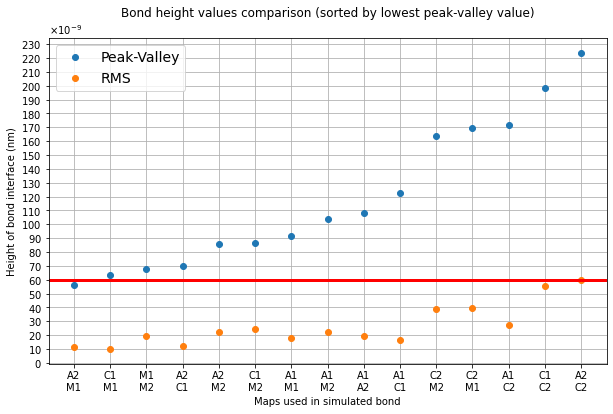

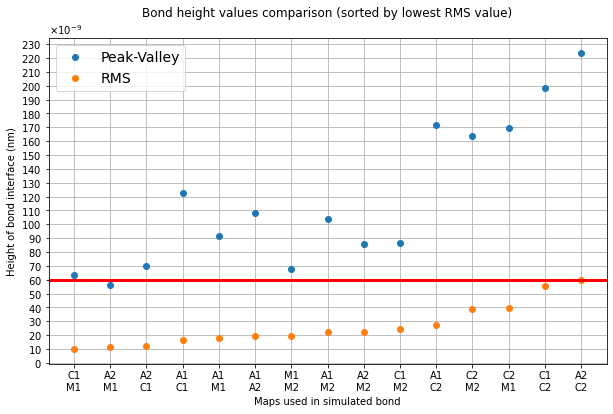

In [12]:
comparebonds(zmaps, sort="both", plot=True)

In [132]:
#applying crops to maps, to compare with edge defects removed
zcropped = []
radius = 32

for i in range(len(zmaps)):
    zmaps[i].crop(radius)  # - note: will change the zmap object, adjust radius back to zero here (or create separate objects)
    zmaps[i].rotateflat()  # - could change crop() to call this automatically
    croppedmap = copy.copy(zmaps[i])  # - to maintain distinct objects (cropped vs uncropped), but share the attributes
    zcropped.append(croppedmap)
    
    #reset original maps
    zmaps[i].crop()
    zmaps[i].rotateflat()

In [14]:
[m.heights.shape[0]//2 - radius for m in zmaps]

[4, 3, 4, 3, 3, 3]

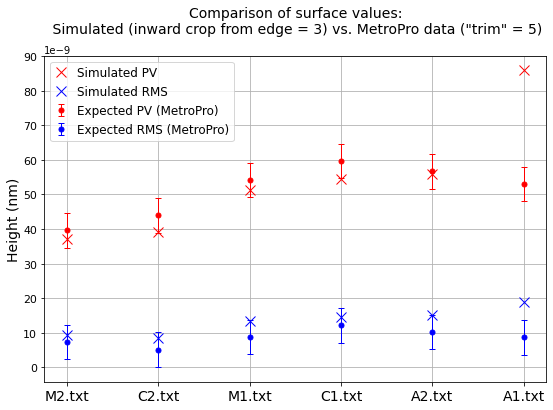

In [15]:
#for individual surfaces (comparison to Zygo/MetroPro screens)
#Zygo maps all used a 5 pixel trim (from edge) => ~ 30 pixel crop radius for all maps
surfPV = np.array([m.peakvalley for m in zcropped])
surfRMS = np.array([m.rms for m in zcropped])
ZygoPV = np.array([53.04, 56.69, 59.61, 43.93, 54.23, 39.63]) * 1e-9
ZygoRMS = np.array([8.67, 10.19, 12.16, 5.08, 8.8, 7.35]) * 1e-9

plt.figure(figsize=(9,6))
plt.plot(surfPV[surfPV.argsort()], "rx", ms=10, label="Simulated PV")
plt.plot(surfRMS[surfPV.argsort()], "bx", ms=10, label="Simulated RMS")
plt.errorbar(range(len(ZygoPV)), ZygoPV[surfPV.argsort()], fmt="r.", yerr=5e-9, ms=10, linewidth=1, capsize=3, label="Expected PV (MetroPro)")
plt.errorbar(range(len(ZygoRMS)), ZygoRMS[surfPV.argsort()], fmt="b.", yerr=5e-9,  ms=10, linewidth=1, capsize=3, label="Expected RMS (MetroPro)")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9))
plt.xticks(range(len(zcropped)), np.array([m.filename for m in zcropped])[surfPV.argsort()])
plt.yticks(np.arange(0,max(surfPV)+10e-9,10e-9))
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=11)
plt.title("Comparison of surface values:\n Simulated (inward crop from edge = {0}) vs. MetroPro data (\"trim\" = 5)\n".format(35-radius), fontsize=14)
plt.ylabel("Height (nm)", fontsize=14, labelpad=2)
plt.legend(ncol=1, handlelength=1, fontsize=12, loc="upper left")
plt.grid()
# plt.savefig("surfComparison3px.png")
plt.show()

#best results when using radius of 32 (~ 3 pixels from edges)
#PV and RMS both match up quite well
#excluding "A1.txt", which has more defects in the interior which need radius ~ 30 to remove
#using the expected radius (5 pixels from edge), the values are systematically lower
#this must be due to the cropping since tilt removal can't produce values that are "too small"
#(data is only transformed, and there is a limit to effect of the rotation)
#Zygo screenshots have a "trim" of 5 pixels, which is not the same as the radial cropping
#this may explain the difference, as the "trim" crops by levels (row/column at a time), not cutting corners so is less severe
#additionally, it can automatically target interior edges at defects, while these would remain in my method

Sample Bonds sorted by lowest peak-to-valley height:

1 -  C1.txt M1.txt
Peak-to-valley Height: 22.1 nm
RMS Height: 3.7 nm


2 -  A2.txt C1.txt
Peak-to-valley Height: 26.9 nm
RMS Height: 6.3 nm


3 -  A2.txt M1.txt
Peak-to-valley Height: 30.0 nm
RMS Height: 6.3 nm


4 -  C2.txt M2.txt
Peak-to-valley Height: 37.7 nm
RMS Height: 8.1 nm


5 -  M1.txt M2.txt
Peak-to-valley Height: 40.9 nm
RMS Height: 14.7 nm


6 -  C1.txt M2.txt
Peak-to-valley Height: 41.1 nm
RMS Height: 15.0 nm


7 -  A2.txt M2.txt
Peak-to-valley Height: 43.0 nm
RMS Height: 17.1 nm


8 -  C2.txt M1.txt
Peak-to-valley Height: 43.9 nm
RMS Height: 12.2 nm


9 -  A2.txt C2.txt
Peak-to-valley Height: 47.7 nm
RMS Height: 15.0 nm


10 -  C1.txt C2.txt
Peak-to-valley Height: 49.5 nm
RMS Height: 18.3 nm


11 -  A1.txt M2.txt
Peak-to-valley Height: 62.4 nm
RMS Height: 15.1 nm


12 -  A1.txt M1.txt
Peak-to-valley Height: 62.7 nm
RMS Height: 17.7 nm


13 -  A1.txt C1.txt
Peak-to-valley Height: 67.2 nm
RMS Height: 18.5 nm


14 -  A1.t

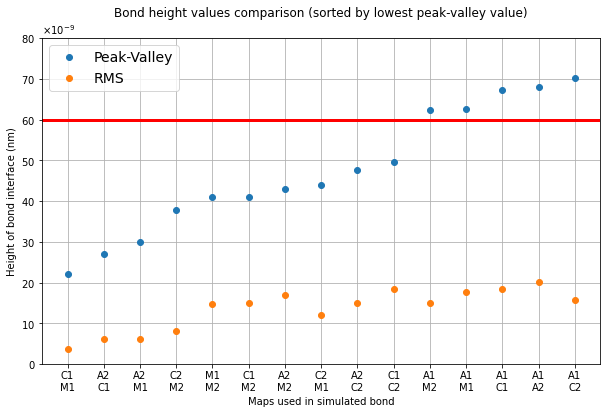

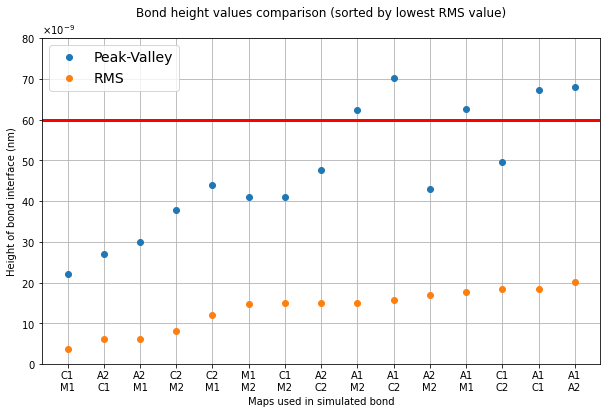

In [16]:
comparebonds(zcropped, sort="both", plot=True)

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


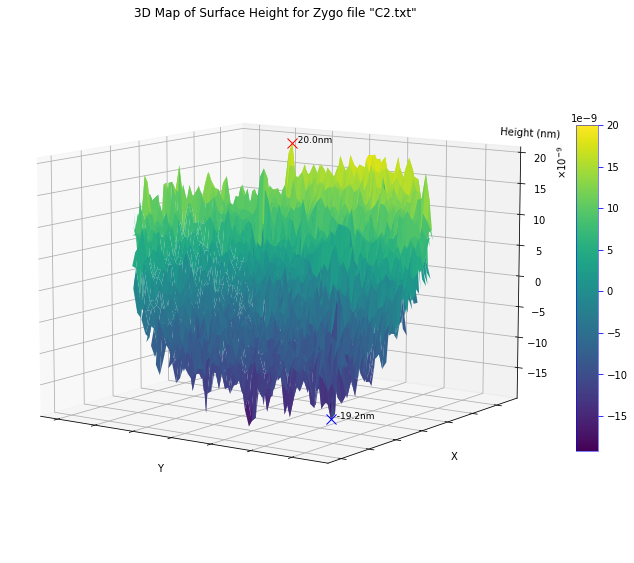

In [17]:
i = 3
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection="3d")
x,y = np.indices(zcropped[i].heights.shape)
peak,valley = np.nanmax(zcropped[i].heights), np.nanmin(zcropped[i].heights)  # - cropped maps, not updated overall pv value
peakxy, valleyxy = np.where(zcropped[i].heights == peak), np.where(zcropped[i].heights == valley)
# ax.set_zlim(zmaps[i].valley, zmaps[i].peak)
ax.set_zlim(valley,peak)
current_cmap = copy.copy(cm.get_cmap("viridis"))

p = ax.plot_surface(x,y, zcropped[i].heights, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)
ax.plot3D(*valleyxy, valley, "bx", zorder=10, ms=10)
ax.plot3D(*peakxy, peak, "rx", zorder=10, ms=10)
ax.text(valleyxy[0][0],valleyxy[1][0],valley, "  {0:.1f}nm".format(valley * 1e9), zorder=10, size=9)
ax.text(peakxy[0][0],peakxy[1][0],peak, "  {0:.1f}nm".format(peak * 1e9), zorder=10, size=9)
# cblabels = [valley, 0, peak]
# cbax = fig.add_axes([0.3,0.6,0.2,0.5])
cb = plt.colorbar(p, pad=0.05, shrink=0.5, aspect=15)#, ticks=[valley, 0, peak])
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("b")
cb.outline.set_linewidth(0.5)
ax.set_title("3D Map of Surface Height for Zygo file \"{}\"".format(zmaps[i].filename), pad=-1000)
plt.ticklabel_format(axis="z", style="sci", scilimits=(-9,-9), useMathText=True)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Y")  # - since matrix i,j are used for axes, spatial x,y should swap
plt.ylabel("X")
ax.set_zlabel("Height (nm)" + "\n"*24)
ax.zaxis._axinfo["label"]["ha"] = "right"
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation("-3")
# ax.zaxis.set_label_coords(0,0)

ax.view_init(elev=10, azim=-55)
# plt.savefig("3Dplot_C2.png")
plt.show()

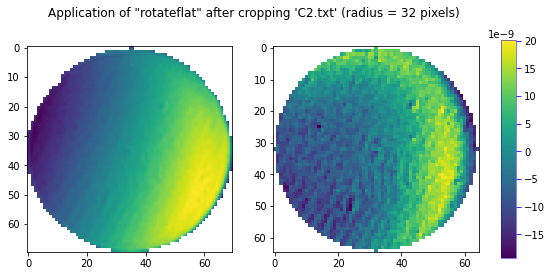

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [18]:
#plotting effects of crop(), and subsequent flattening after the crop
fig,ax = plt.subplots(1,2, sharey="col",sharex=False, figsize=(10,10))
p1=ax[0].imshow(zmaps[i].heights)
zmaps[i].crop(radius)
zmaps[i].rotateflat()
p2=ax[1].imshow(zmaps[i].heights)
fig.suptitle("Application of \"rotateflat\" after cropping {0} (radius = {1} pixels)".format(repr(zmaps[i].filename), radius), y=0.7, x=0.44)
cb=plt.colorbar(p2,ax=ax, shrink=0.4, aspect=15, pad=0.04)
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("b")
cb.outline.set_linewidth(0.5)

# fig.subplots_adjust(hspace=0, wspace=0.1)
# plt.savefig("crop&rotateEffectC2.png")
plt.show()
zmaps[i].crop()
zmaps[i].rotateflat()

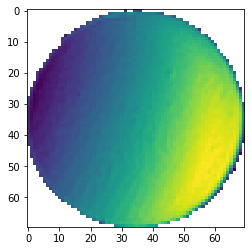

In [19]:
plt.imshow(zmaps[i].heights)
plt.plot(*np.where(zmaps[i].heights == peak)[::-1], "rx", ms=10)
plt.plot(*np.where(zmaps[i].heights == valley)[::-1], "rx", ms=10)
# plt.plot(*valleyxy[::-1], "ro")
plt.show()

In [20]:
np.where(zmaps[i].heights == valley)

(array([], dtype=int64), array([], dtype=int64))

In [21]:
np.where(zmaps[i].heights == peak)

(array([], dtype=int64), array([], dtype=int64))

In [22]:
# ax.contour3D.__doc__

In [23]:
# ax.xaxis.set

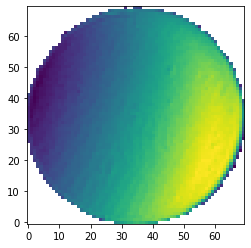

In [24]:
plt.imshow(zmaps[i].heights[::-1], origin="lower")
# plt.clim(-1e-9,1e-9)
# plt.colorbar(extend="both")
plt.show()

In [25]:
# ax.zaxis.__dir__()

In [26]:
# ax.zaxis.label.set_verticalalignment.__doc__

In [27]:
# ax.zaxis.label.__dir__()

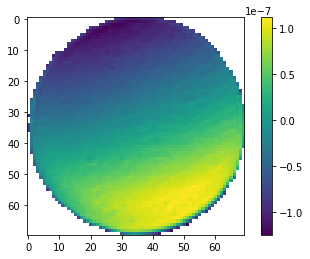

In [28]:
plt.imshow(zmaps[i].heights.T)
plt.colorbar()
plt.show()

In [29]:
print(plt.axes.__doc__)

Add an axes to the current figure and make it the current axes.

Call signatures::

    plt.axes()
    plt.axes(rect, projection=None, polar=False, **kwargs)
    plt.axes(ax)

Parameters
----------
arg : None or 4-tuple
    The exact behavior of this function depends on the type:

    - *None*: A new full window axes is added using
      ``subplot(111, **kwargs)``.
    - 4-tuple of floats *rect* = ``[left, bottom, width, height]``.
      A new axes is added with dimensions *rect* in normalized
      (0, 1) units using `~.Figure.add_axes` on the current figure.

projection : {None, 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', str}, optional
    The projection type of the `~.axes.Axes`. *str* is the name of
    a custom projection, see `~matplotlib.projections`. The default
    None results in a 'rectilinear' projection.

polar : bool, default: False
    If True, equivalent to projection='polar'.

sharex, sharey : `~.axes.Axes`, optional
    Share the x or y `~matp

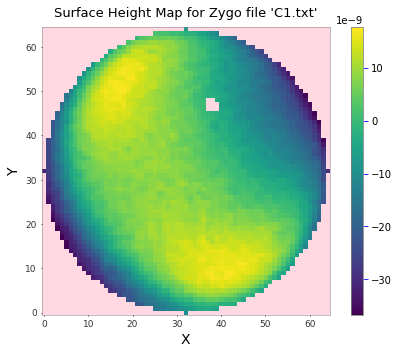

In [30]:
i = 2
ax=plt.axes((0,0,1,1), fc="#FFD8E2")
for side in ax.spines:
    ax.spines[side].set_edgecolor("gray")
    ax.spines[side].set_linewidth(0.5)
    #ax.spines[side].set_visible(False)
    
    
current_cmap = copy.copy(cm.get_cmap("viridis"))
plt.imshow(zcropped[i].heights[::-1], cmap=current_cmap, origin="lower")
# - to present spatial rather than matrix order, use origin="lower" to invert y-axis, and plot the flipped array instead
plt.title("Surface Height Map for Zygo file {0}".format(repr(zmaps[i].filename)), fontsize=13, pad=10)
cb = plt.colorbar(pad=0.05, shrink=1, aspect=25)#, ticks=[valley, 0, peak])
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("gray")
cb.outline.set_linewidth(0.8)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)

for tick in ax.xaxis.get_ticklabels():
#     tick.set_color("#444444")
    tick.set_alpha(0.8)
    tick.set_fontsize(9)
for tick in ax.yaxis.get_ticklabels():
#     tick.set_color("#444444")
    tick.set_alpha(0.8)
    tick.set_fontsize(9)
    
# ax.yaxis.set_ticklabels(yticks[::-1])
# ax.axes.invert_yaxis()
# ax.xaxis.set_major_locator(plt.NullLocator())  # - removes all (or specifically major ?) axis ticks/labels
ax.tick_params(axis="both", length=1, pad=4)
plt.show()

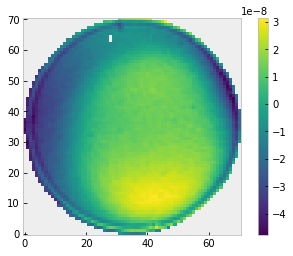

In [31]:
#this one is quite good, colorbar included
with plt.style.context("bmh"):
#     ax=plt.axes((0,0,1,1))
    plt.imshow(zmaps[1].heights[::-1], origin="lower")
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [32]:
ax.yaxis.get_ticklabels()[0].__dir__()

['_stale',
 'stale_callback',
 '_axes',
 'figure',
 '_transform',
 '_transformSet',
 '_visible',
 '_animated',
 '_alpha',
 'clipbox',
 '_clippath',
 '_clipon',
 '_label',
 '_picker',
 '_contains',
 '_rasterized',
 '_agg_filter',
 '_mouseover',
 'eventson',
 '_oid',
 '_propobservers',
 '_remove_method',
 '_url',
 '_gid',
 '_snap',
 '_sketch',
 '_path_effects',
 '_sticky_edges',
 '_in_layout',
 '_x',
 '_y',
 '_text',
 '_color',
 '_fontproperties',
 '_usetex',
 '_wrap',
 '_verticalalignment',
 '_horizontalalignment',
 '_multialignment',
 '_rotation',
 '_bbox_patch',
 '_renderer',
 '_linespacing',
 '_rotation_mode',
 '__module__',
 '__doc__',
 'zorder',
 '_cached',
 '__repr__',
 '__init__',
 'update',
 '__getstate__',
 'contains',
 '_get_xy_display',
 '_get_multialignment',
 'get_rotation',
 'set_rotation_mode',
 'get_rotation_mode',
 'update_from',
 '_get_layout',
 'set_bbox',
 'get_bbox_patch',
 'update_bbox_position_size',
 '_draw_bbox',
 '_update_clip_properties',
 'set_clip_box',
 'se

In [33]:
ax.spines["right"]

In [34]:
ax.spines["right"].__dir__()

['_stale',
 'stale_callback',
 '_axes',
 'figure',
 '_transform',
 '_transformSet',
 '_visible',
 '_animated',
 '_alpha',
 'clipbox',
 '_clippath',
 '_clipon',
 '_label',
 '_picker',
 '_contains',
 '_rasterized',
 '_agg_filter',
 '_mouseover',
 'eventson',
 '_oid',
 '_propobservers',
 '_remove_method',
 '_url',
 '_gid',
 '_snap',
 '_sketch',
 '_path_effects',
 '_sticky_edges',
 '_in_layout',
 '_hatch_color',
 '_fill',
 '_original_edgecolor',
 '_edgecolor',
 '_original_facecolor',
 '_facecolor',
 '_us_dashes',
 '_linewidth',
 '_linestyle',
 '_dashoffset',
 '_dashes',
 '_antialiased',
 '_hatch',
 '_capstyle',
 '_joinstyle',
 'spine_type',
 'axis',
 'zorder',
 '_bounds',
 '_smart_bounds',
 '_position',
 '_path',
 '_patch_type',
 '_patch_transform',
 '__module__',
 '__doc__',
 '__str__',
 '__init__',
 'set_smart_bounds',
 'get_smart_bounds',
 'set_patch_arc',
 'set_patch_circle',
 'set_patch_line',
 '_recompute_transform',
 'get_patch_transform',
 'get_window_extent',
 'get_path',
 '_ensur

In [35]:
zmaps[1].__dict__

{'filename': 'A2.txt',
 'stringConstant': 'Zygo ASCII Data File - Format 2',
 'softwareType': 1,
 'majorVersion': 7,
 'minorVersion': 6,
 'bugVers': 1,
 'softwareDate': 'Thu Aug 09 10:21:55 2001     ',
 'intensOriginX': 0,
 'intensOriginY': 0,
 'intensWidth': 320,
 'intensHeight': 240,
 'Nbuckets': 1,
 'intensRange': 255,
 'phaseOriginX': 61,
 'phaseOriginY': 105,
 'phaseWidth': 105,
 'phaseHeight': 97,
 'comment': '                                                                                 ',
 'partSerNum': '                                       ',
 'partNum': '                                       ',
 'source': 0,
 'timeStamp': 1464950435,
 'intfScaleFactor': 0.5,
 'wavelengthIn': 6.328e-07,
 'numericAperture': 0.0,
 'obliquityFactor': 1.0,
 'magnification': 0.0,
 'cameraRes': 0.0,
 'cameraWidth': 320,
 'cameraHeight': 240,
 'systemType': 4,
 'systemBoard': 0,
 'systemSerial': -4317,
 'instrumentId': 0,
 'objectiveName': 'Sm Aperture',
 'targetRange': 0.1,
 'lightLevel': 78.52

In [36]:
grid = plt.GridSpec(3,3, wspace=0.5,hspace=0.1)

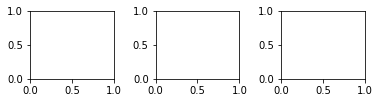

In [37]:
plt.subplot(grid[0,0])
plt.subplot(grid[0,1])
plt.subplot(grid[0,2])
plt.show()

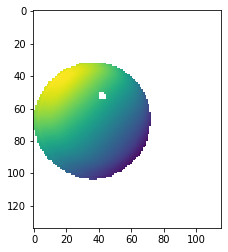

In [38]:
grid = plt.GridSpec(3,3, wspace=0.5,hspace=0.1)
ax1 = plt.subplot(grid[0:])
# ax2 = plt.subplot(grid[0,1])
# ax3 = plt.subplot(grid[0,2])
ax1.imshow(zmaps[i].heights0)
plt.show()

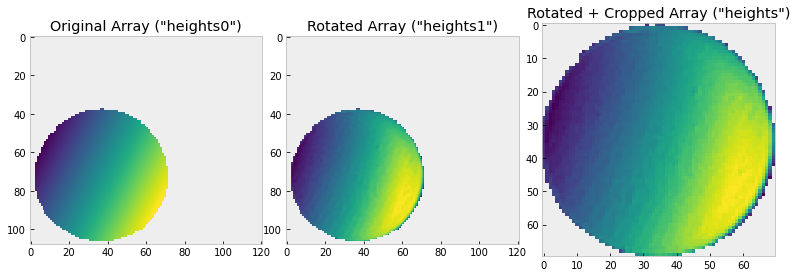

In [39]:
j = 3
with plt.style.context("bmh"):
    current_cmap = copy.copy(cm.get_cmap("viridis"))
    fig,ax = plt.subplots(1,3, sharex=False,sharey="col", figsize=(18,18))

#     for j in range(len(zmaps)):
#         for a in ax[j]:
#             a.grid(False)
    for a in ax:
        a.grid(False)
            
    ax[0].imshow(zmaps[j].heights0, cmap=current_cmap)
#         ax[j,0].colorbar()
    ax[0].set_title("Original Array (\"heights0\")")
    ax[1].imshow(zmaps[j].heights1, cmap=current_cmap)
#         ax[j,1].colorbar()
    ax[1].set_title("Rotated Array (\"heights1\")")
    im = ax[2].imshow(zmaps[j].heights, cmap=current_cmap)
#         ax[j,2].colorbar()
    ax[2].set_title("Rotated + Cropped Array (\"heights\")")
#     ax[2].set_aspect(0.9)

    fig.subplots_adjust(hspace=0,wspace=0.1, right=0.7)
#     cbax = fig.add_axes([0.55,0.42,0.02,0.15])
#     cb = fig.colorbar(im,cax=cbax, cmap=current_cmap)
#     cb.formatter.set_scientific(True)
#     cb.formatter.set_powerlimits((-9,-9))
    plt.show()

In [40]:
from decimal import Decimal

In [41]:
Decimal(zmaps[1].peakvalley)

Decimal('7.9522463644786335562085542554011663440860502305440604686737060546875E-8')

In [42]:
n = Decimal(zmaps[1].peakvalley / 1e-9).quantize(Decimal("0." + "e-9"))
n

Decimal('79.522463645')

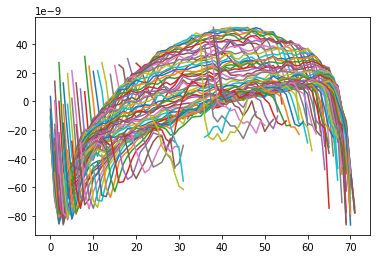

In [43]:
plt.plot(zmaps[0].heights)
plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9))
plt.show()

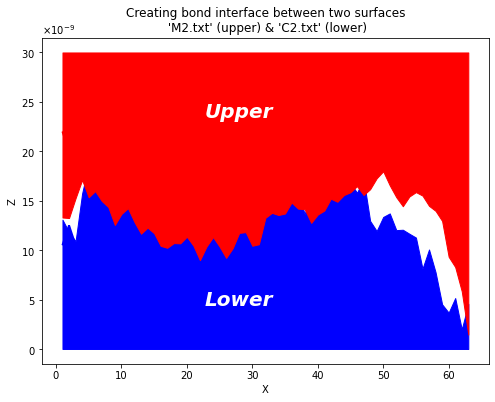

In [44]:
# plt.plot(zcropped[5].heights[:,35] + zcropped[3].valley/2, "r-")
# plt.plot(-zcropped[3].heights[:,35][::-1] + zcropped[3].valley/0.5, "b-")
plt.figure(figsize=(8,6))
Xlow = np.arange(zcropped[3].heights.shape[0])
Ylow = -zcropped[3].heights[:,35][::-1].ravel() + zcropped[3].peak/1.4
Xupp = np.arange(zcropped[5].heights.shape[0])[::-1]
Yupp = zcropped[5].heights[:,35][::-1].ravel() + zcropped[5].valley
plt.fill_between(Xlow,Ylow, 0e-8, color="b", label="Upper Surface (flipped+negative heights)")
plt.fill_between(Xupp,3e-8,Yupp+3e-8, color="r", label="Lower Surface")
# plt.legend()
plt.arrow(2,2.5e-8, 0, -3e-9, head_width=2, head_length=1e-9, overhang=2, linewidth=2, color="r")
plt.arrow(2,0.75e-8, 0, +3e-9, head_width=2, head_length=1e-9, overhang=2, linewidth=2, color="b")

plt.title("Creating bond interface between two surfaces\n {0} (upper) & {1} (lower)".format(repr(zmaps[5].filename), repr(zmaps[3].filename)))
plt.xlabel("X")
plt.ylabel("Z")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9), useMathText=True)
plt.text(28,24e-9, "Upper", size=20, ha="center", va="center", color="w", weight=600, style="oblique")
plt.text(28,5e-9, "Lower", size=20, ha="center", va="center", color="w", weight=600, style="oblique")
# plt.plot(50,39e-9, marker=r'$\curvearrowright$',ms=100, color="k")
# plt.savefig("interface_after.png")
plt.show()

In [45]:
mm = combinemaps(zcropped[5], zcropped[3])

Maps combined for optimal angle of 40.88 degrees
            C2.txt clockwise w.r.t M2.txt
Optimised peak-to-valley height: 3.6979675041746326e-08 m
Optimised RMS height: 8.097342334233197e-09 m


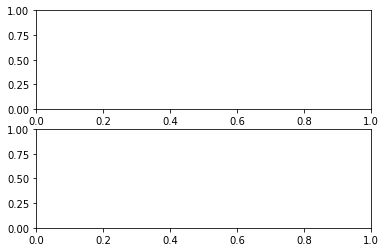

In [46]:
fig, ax = plt.subplots(2,1)

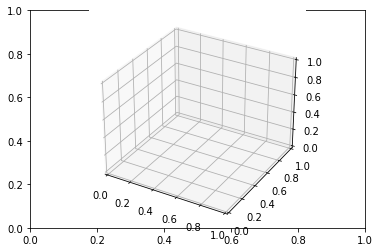

In [47]:
fig,ax = plt.subplots()
fig.add_subplot(projection="3d")
plt.show()

In [48]:
mpairs = np.array(list(combinations(zcropped, 2)))
imaps = np.zeros(len(mpairs), dtype=object)
for i in range(len(mpairs)):
    combo = mpairs[i]
    interfacemap = combinemaps(*combo, output=False)
    interfacemap.heights += abs(np.nanmin(interfacemap.heights))  # - more useful to give the interface in absolute height (start from zero minimum)
    imaps[i] = interfacemap

In [49]:
[[imap.map1,imap.map2] for imap in imaps]

[['A1.txt', 'A2.txt'],
 ['A1.txt', 'C1.txt'],
 ['A1.txt', 'C2.txt'],
 ['A1.txt', 'M1.txt'],
 ['A1.txt', 'M2.txt'],
 ['A2.txt', 'C1.txt'],
 ['A2.txt', 'C2.txt'],
 ['A2.txt', 'M1.txt'],
 ['A2.txt', 'M2.txt'],
 ['C1.txt', 'C2.txt'],
 ['C1.txt', 'M1.txt'],
 ['C1.txt', 'M2.txt'],
 ['C2.txt', 'M1.txt'],
 ['C2.txt', 'M2.txt'],
 ['M1.txt', 'M2.txt']]

In [50]:
print(imaps[0])

zygomap interface object for 'A1.txt' & 'A2.txt' combined at angle 276 degrees. 
Peak-to-valley height of bond: 6.8009e-08 m 
RMS height of bond: 2.0102e-08 m


In [51]:
print(len(mpairs))
# (i < 15 below)

15


/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


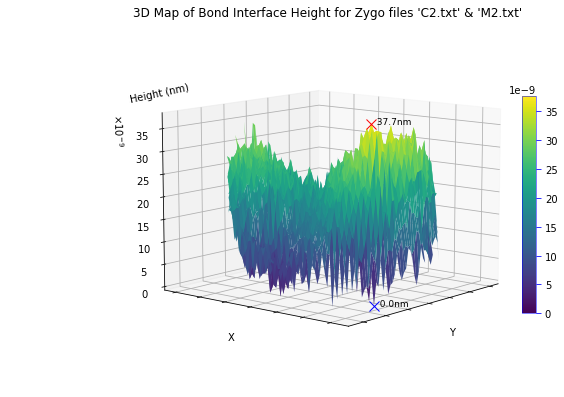

In [52]:
i = 13
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
x,y = np.indices(imaps[i].heights.shape)
peak,valley = np.nanmax(imaps[i].heights), np.nanmin(imaps[i].heights)  # - cropped maps, not updated overall pv value
peakxy, valleyxy = np.where(imaps[i].heights == peak), np.where(imaps[i].heights == valley)
# ax.set_zlim(imaps[i].valley, imaps[i].peak)
ax.set_zlim(valley,peak)
current_cmap = copy.copy(cm.get_cmap("viridis"))

p = ax.plot_surface(x,y, imaps[i].heights, vmin=valley, vmax=peak, cmap=current_cmap, ccount=1000, rcount=1000)
ax.plot3D(*valleyxy, valley, "bx", zorder=10, ms=10)
ax.plot3D(*peakxy, peak, "rx", zorder=10, ms=10)
# cset = ax.contourf(x, y, imaps[i].heights, zdir='z', offset=0, cmap=current_cmap)
ax.text(valleyxy[0][0],valleyxy[1][0],valley, "  {0:.1f}nm".format(valley * 1e9), zorder=10, size=9)  # - chose to show interface from valley at zero, no need to label that
ax.text(peakxy[0][0],peakxy[1][0],peak, "  {0:.1f}nm".format(peak * 1e9), zorder=10, size=9)
# cblabels = [valley, 0, peak]
cb = plt.colorbar(p, pad=0.02, shrink=0.5, aspect=15)#, ticks=[valley, 0, peak])
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("b")
cb.outline.set_linewidth(0.5)
ax.set_title("3D Map of Bond Interface Height for Zygo files {0} & {1}".format(repr(imaps[i].map1), repr(imaps[i].map2)), pad=-1000)
plt.ticklabel_format(axis="z", style="sci", scilimits=(-9,-9), useMathText=True)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Y")  # - since matrix i,j are used for axes, spatial x,y should swap
plt.ylabel("X")
ax.set_zlabel("                                        Height (nm)" + "\n"*17)
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation("12")
# ax.zaxis.set_label_coords(0,0)

ax.view_init(elev=10, azim=40)
# plt.savefig("3Dinterface_A1A1.png")
plt.show()

### testing z-axis optimal angle
Use two step-function maps, one the transpose of the other - thus knowing that we expect 90 degree optimal angle and the interface should be all zero when combining with one flipped w.r.t the other.

In [53]:
msk = np.zeros((70,70))
msk[msk.shape[0]//2:,] = 1
msk

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

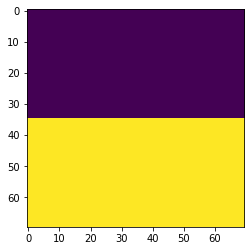

In [54]:
plt.imshow(msk)
plt.show()

In [55]:
#adjust from single discontinuous step to a sharp slope across the middle
array1 = msk*50
for i in range(5):
    array1[msk.shape[0]//2 - i,] = 50 - 10*i
array1

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.]])

In [56]:
array1[msk.shape[0]//2 - 1]

array([40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40.])

In [57]:
array2 = array1.T
array2

array([[ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       ...,
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.]])

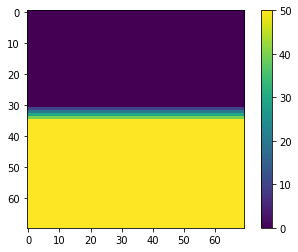

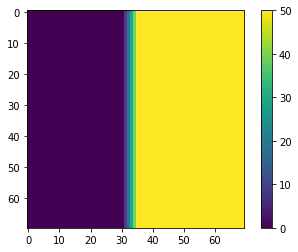

In [58]:
plt.imshow(array1)
plt.colorbar()
plt.show()
plt.imshow(array2)
plt.colorbar()
plt.show()

In [59]:
#had to add "flatten" keyword to allow a zygomap object which uses the exact array provided (without rotating it to be flat)
m1 = zygomap(array=array1, flatten=False)
m2 = zygomap(array=array2, flatten=False)

In [60]:
#note: using flatten=True with these maps may see map disappear outside the initial bounds
#the rotation method avoids increasing bounds, as an arbitrary height may be rotated into x or y
#thus vastly enlarging array dimensions to arbitrary, unconstrained sizes (problematic/catastrophic)
#some constraint could be added for general maps, but for the zygomaps it doesn't affect things
# m3 = zygomap(array=array1, flatten=True)
# plt.imshow(m3.heights0)
# plt.show()
# plt.imshow(m3.heights1)
# plt.show()
# plt.imshow(m3.heights)
# plt.show()

In [61]:
print(m1)

zygomap object for user-provided array. 
Peak-to-valley height: 5.0000e+01 m 
RMS height: 3.5956e+01 m


In [62]:
m1.heights1

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.],
       [50., 50., 50., ..., 50., 50., 50.]])

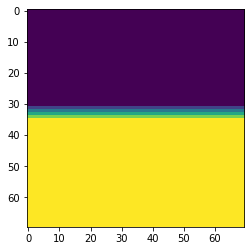

In [63]:
plt.imshow(m1.heights1)
plt.show()

In [64]:
#output as expected
combinemaps(m1,m2)

Maps combined for optimal angle of 90.00 degrees
            (map2 clockwise w.r.t map1)
Optimised peak-to-valley height: 0.0 m
Optimised RMS height: 0.0 m


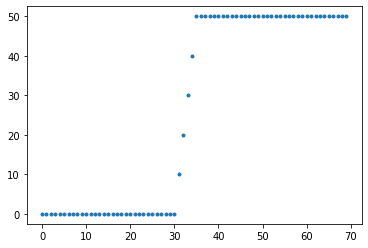

In [65]:
plt.plot(m1.heights[:,30], ".")
plt.show()

In [66]:
scipy.ndimage.rotate

<function scipy.ndimage.interpolation.rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)>

In [67]:
u = scipy.ndimage.rotate(m1.heights, 90, order=0, reshape=False, mode="constant", cval=np.nan)
u

array([[ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       ...,
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.],
       [ 0.,  0.,  0., ..., 50., 50., 50.]])

In [68]:
np.nanmax(-u[::-1] + m2.heights), np.nanmin(-u[::-1] + m2.heights)

(0.0, 0.0)

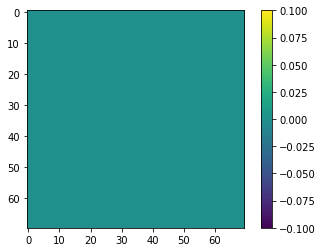

In [69]:
plt.imshow(-u[::-1] + m2.heights)
plt.colorbar()
plt.show()

In [70]:
[l//2 for l in m1.heights.shape]

[35, 35]

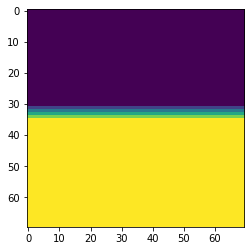

In [71]:
plt.imshow(array1)
plt.show()

In [72]:
w = rotatepoints(array1, np.array([1,1,0]), angle=np.pi/6, centre=[35,35], getheights=True)
w

array([[         nan,          nan,          nan, ..., -30.21979474,
        -29.86624135, -29.51268796],
       [         nan,          nan,          nan, ..., -30.57334813,
        -30.21979474, -29.86624135],
       [         nan,          nan,          nan, ..., -30.92690152,
        -30.57334813, -30.21979474],
       ...,
       [         nan,          nan,          nan, ...,   0.        ,
          0.35355339,   0.70710678],
       [         nan,          nan,          nan, ...,  -0.35355339,
          0.        ,   0.35355339],
       [         nan,          nan,          nan, ...,  -0.70710678,
         -0.35355339,   0.        ]])

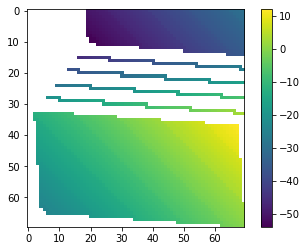

In [73]:
plt.imshow(w)
plt.colorbar()
plt.show()

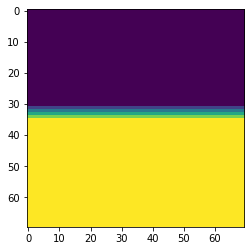

In [74]:
plt.imshow(m1.heights)
plt.show()

In [75]:
w = rotatepoints(m1.heights, np.array([1,1,0]), angle=np.pi/4, centre=[35,35], getheights=False)
w

array([[-25.        ,  25.        , -35.35533906],
       [-24.85355339,  25.85355339, -34.85533906],
       [-24.70710678,  26.70710678, -34.35533906],
       ...,
       [ 68.70710678,  67.29289322,  -1.        ],
       [ 68.85355339,  68.14644661,  -0.5       ],
       [ 69.        ,  69.        ,   0.        ]])

In [76]:
x,y = np.indices(m1.heights.shape)
h = griddata((w[:,0],w[:,1]), w[:,2], (x,y), method="linear", rescale=False, fill_value=np.nan)
h

array([[            nan,             nan,             nan, ...,
        -2.33345238e+01, -2.26274170e+01, -2.19203102e+01],
       [            nan,             nan,             nan, ...,
        -2.40416306e+01, -2.33345238e+01, -2.26274170e+01],
       [            nan,             nan,             nan, ...,
        -2.47487373e+01, -2.40416306e+01, -2.33345238e+01],
       ...,
       [            nan,             nan,             nan, ...,
         0.00000000e+00,  7.07106781e-01,  5.85786438e-01],
       [            nan,             nan,             nan, ...,
        -7.07106781e-01, -5.55111512e-17,  2.92893219e-01],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  0.00000000e+00]])

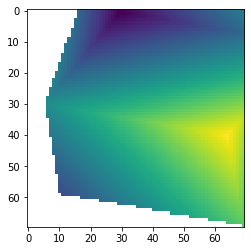

In [77]:
#griddata interpolation will struggle with these shapes of large slopes/discontinuities
plt.imshow(h)
plt.show()

### testing effects of large tilt in supplied array

In [78]:
a = np.ones((70,70))
a

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [79]:
x,y = np.indices(a.shape)
outsideR = (x-35)**2 + (y-35)**2 > 30**2
a[outsideR] = np.nan
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [80]:
#use array "b" to test with a significantly tilted array
#copy from "a" which already has circular mask applied
b = a.copy()
b

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [81]:
#tilt the flat, circular "b" array to use as a heavily-tilted input for a map
btilt = rotatepoints(b, np.array([1,0,0]), np.pi/3, centre=[35,35], getheights=True)
btilt

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

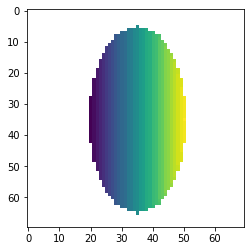

In [82]:
plt.imshow(btilt)
plt.show()

In [83]:
#use this tilted array as input for map, and see the effect of the rotateflat() function
l = zygomap(array=btilt, flatten=True)
l.heights

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

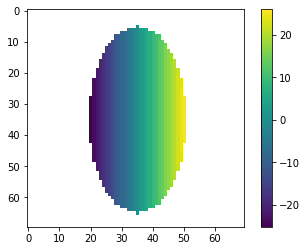

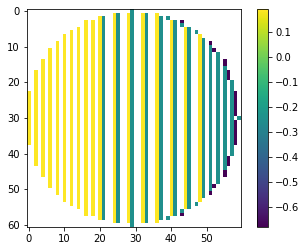

In [84]:
plt.imshow(btilt)
plt.colorbar()
plt.show()
plt.imshow(l.heights)
plt.colorbar()
plt.show()

#need to have a look at ordering of cropping & rotating
#cropping then rotating may lose data outside for significant tilts
#crop() method uses heights0 as base for the array to crop - thus ignoring the rotation
#for this reason I have been cropping first, which is OK for small angles of tilts assumed for zygo data
#could re-define crop to be adaptable to whether the radius is increasing or decreasing -> two different cases
#reducing means we use self.heights, but increasing means having to go back to original self.heights0 (difficult ?)
#the question is when to rotateflat() so that crop() takes into account the full extent of valid points from flattened array

#NOTE: added a 3rd array "self.heights1" - which stores the flattened version of heights0
#since crop() needs the full array to be able to both reduce and increase the data shown, it was using heights0
#but that would undo the flattening each time
#cannot crop and then flatten, as this restricts the view even if the flattened version extended further outside

In [85]:
#so we can see that there are gaps in series of data in the array
#due to tilted array covering smaller area - there is no existing data to expand into the larger area of flattened array
ld = rotatepoints(l.heights, np.array([1,0,0]), 0, centre=[35,35], getheights=False)
ld

array([[ 0.       , 29.       , -0.2446566],
       [ 1.       , 24.       ,  0.1883561],
       [ 1.       , 25.       , -0.2446566],
       ...,
       [59.       , 33.       , -0.2446566],
       [59.       , 36.       ,  0.1883561],
       [60.       , 29.       , -0.2446566]])

In [86]:
# plt.imshow(ld)
# plt.show()

In [87]:
#attempt some interpolation with griddata()
X,Y = np.indices(l.heights.shape)
lg = griddata((ld[:,0],ld[:,1]), ld[:,2], (X,Y))
lg

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

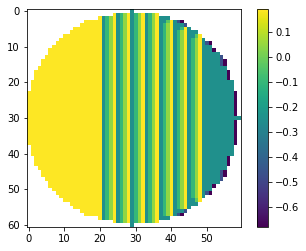

In [88]:
#here we have examined when a significant tilt results in sparse data upon flattening (see l.heights above)
#possible to interpolate the rotation with griddata, using the x,y columns of the vectarray (produced above via rotatepoints)
#this would be a suitable place to employ interpolation
#would not expect the above issue in the zygomaps, however interpolating may be a good idea in any case
plt.imshow(lg)
plt.colorbar()
plt.show()

In [89]:
#conclusion: the rotation methods can work with the zygo maps
#however there are some pitfalls for unconstrained shapes
#ditching rotation for a best-fit plane is probably the better solution

In [90]:
bl = zmaps[0].rotateflat(btilt)  # - note: using zmaps[0] to access the function, but can pass any MxN array. 
#This will overwrite zmaps[0].heights so not practical
bl

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

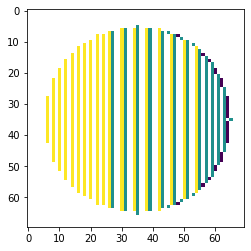

In [91]:
plt.imshow(bl)
plt.show()

### testing effects of large peaks in maps

In [92]:
a = np.ones((70,70))
x,y = np.indices(a.shape)
outsideR = (x-35)**2 + (y-35)**2 > 30**2  # - using example radius of 30
a[outsideR] = np.nan
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [93]:
#testing an untilted item, approaching a sharp point of size larger than grid dimensions
#use 3 test cases for peak height:
# 1) relatively small (compared to dimensions of valid points) e.g. peak = 5
# 2) equal to valid points range (i.e. diameter) peak = 70
# 3) much larger than valid points range, e.g. peak = 1000
amicro = a * 1e-9/((x-35)**2 + (y-35)**2 + 1)
asmall = a * 5/((x-35)**2 + (y-35)**2 + 1)
amedium = a * 70/((x-35)**2 + (y-35)**2 + 1)
alarge = a * 1000/((x-35)**2 + (y-35)**2 + 1)
# asmall

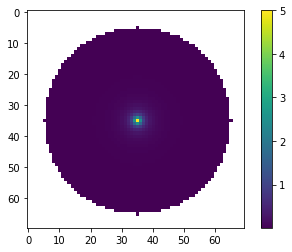

In [94]:
# plt.imshow(amicro)
plt.imshow(asmall)
# plt.imshow(amedium)
# plt.imshow(alarge)
plt.colorbar()
plt.show()

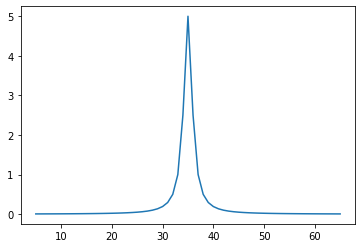

In [95]:
plt.plot(asmall[:,35])
plt.show()

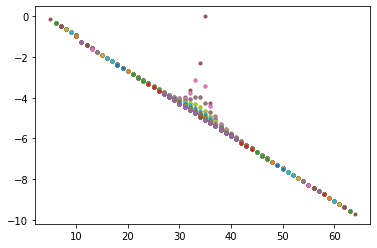

In [96]:
plt.plot(rotatepoints(asmall, np.array([0,1,0]), 16e-2, centre=[35,35], getheights=True), ".")
plt.show()

In [97]:
s = rotatepoints(asmall, np.array([0,1,0]), 0, centre=[35,35], getheights=False)
s

array([[ 5.        , 35.        , -4.99445061],
       [ 6.        , 28.        , -4.99438833],
       [ 6.        , 29.        , -4.99430524],
       ...,
       [64.        , 41.        , -4.99430524],
       [64.        , 42.        , -4.99438833],
       [65.        , 35.        , -4.99445061]])

In [98]:
np.nanmax(s[:,2]), np.nanmin(s[:,2])

(0.0, -4.994450610432852)

In [99]:
#using maximum height at peak of 50:
#with zero rotation, peak-valley height is 49.9445 (min. is > 0 actually: ~ 0.05549)
#thus, almost any rotation angle is going to increase peak-valley height

#using peak >> grid dimensions:
#the true way to minimise peak-valley height here would be to flip 90 degrees
#then the peak lies "flat" in x-y and the grid dimensions become the peak-valley max.
#rotateflat() wouldn't find that due to the minimisation algorithm looking near to an initial "guess"
#so this maintains the expected direction in this case, but if using "brute" minimiser it may perform differently

# => 2 general cases, for if the peak is larger than the max. grid size or smaller
#each will look for very small angles:
#the peak < dims case: finds almost any non-zero rotation adds to the peak-valley height as the tilt dominates
#the peak > dims case: finds zero rotation to be optimal, fails to find true value at 90
np.nanmax(s[:,2]) - np.nanmin(s[:,2])

4.994450610432852

In [100]:
amap = zygomap(array=asmall)
amap

In [101]:
print(scipy.optimize.brute.__doc__)

Minimize a function over a given range by brute force.

    Uses the "brute force" method, i.e., computes the function's value
    at each point of a multidimensional grid of points, to find the global
    minimum of the function.

    The function is evaluated everywhere in the range with the datatype of the
    first call to the function, as enforced by the ``vectorize`` NumPy
    function. The value and type of the function evaluation returned when
    ``full_output=True`` are affected in addition by the ``finish`` argument
    (see Notes).

    The brute force approach is inefficient because the number of grid points
    increases exponentially - the number of grid points to evaluate is
    ``Ns ** len(x)``. Consequently, even with coarse grid spacing, even
    moderately sized problems can take a long time to run, and/or run into
    memory limitations.

    Parameters
    ----------
    func : callable
        The objective function to be minimized. Must be in the
        form ``

In [102]:

opts={"ftol":1e-15,"xtol":1e-15,"maxiter":1000}
for arr in (amicro,asmall,amedium,alarge):
    params = scipy.optimize.minimize(zmaps[0].testf, x0=[0,np.pi/5], args=arr, method="Nelder-Mead", tol=1e-15)
    print(params["x"], params["fun"])

[3.52339880e-17 6.49016612e-17] 9.988923139382228e-10
[ 2.21094224e-17 -8.03995704e-17] 4.994450610432855
[0.13058503 1.16549327] 54.670198906392905
[0.14188243 1.5407713 ] 59.37103537696819


In [103]:
print(amap.peakvalley)  # - so there is some attempt to rotate, leading to a peak slightly below the 100 value of entered array "a"
#this pretty much finds the unrotated array as minimised
#as the initial "guess" is near zero
#yet the true optimal angle is at 90 degrees (looking at completely wrong end of scale)

4.994450610432852


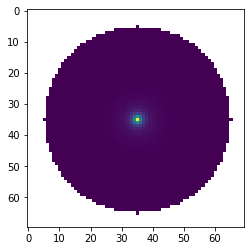

In [104]:
plt.imshow(amap.heights1)
plt.show()

In [105]:
wa = rotatepoints(a, axis=np.array([1,0,0]), angle=np.pi/4, centre=[35,35], getheights=True)
wa

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

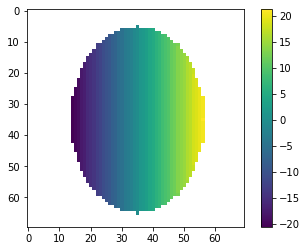

In [106]:
#example of rotating that peak, see a clear issue with representing with enough resolution for a clear shape
#but the tilt and peak proceeding outside the bounds are visible
#some nan's appear around the peak, again due to the representation of points and overlapping values onto grid points
plt.imshow(wa)
plt.colorbar()
plt.show()

In [107]:
Rot.from_rotvec(np.pi/4 * np.array([1,0,0])).apply([35,35,100])

array([ 35.        , -45.96194078,  95.45941546])

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


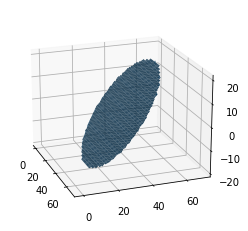

In [108]:
#showing the issues with representing shape with flat grid
#does not distinguish multiple overlapping parts, see non-physical joining of peak to surface
#if 3D plotting necessary, will have to store co-ordinates more generally
#then the various representations would not be the basis for storing the data, rather produced from a more general storage of points
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")

p = ax1.plot_surface(x,y,wa, rstride=1,cstride=1, linewidth=0.5, antialiased=True)
# cset = ax1.contour(x,y,wa, 40, zdir='z', offset=-20)

ax1.view_init(elev=20, azim=-20)
plt.show(fig)

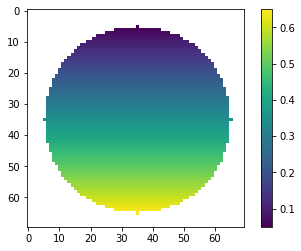

In [109]:
plt.imshow(a * x/100)
plt.colorbar()
plt.show()

In [110]:
a2 = zygomap(array=a*x/3)
a2

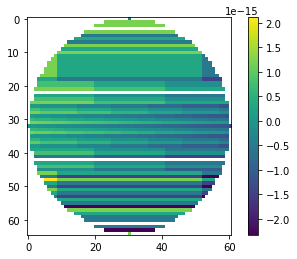

In [111]:
plt.imshow(a2.heights)
plt.colorbar()
plt.show()
#larger tilts will see clear defects in allocating points correctly when rotating

In [112]:
# a3 = zmaps[0].rotateflat(a2.heights.copy())
# a3

In [113]:
# plt.imshow(a3)
# plt.colorbar()
# plt.show()

In [114]:
a4 = rotatepoints(a*x/10, np.array([0,1,0]), 9.9668e-2, centre=[35,35], getheights=True)
a4

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

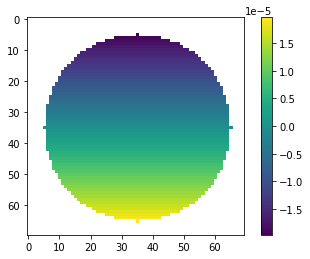

In [115]:
plt.imshow(a4)
plt.colorbar()
plt.show()

In [116]:
radii = [m.heights.shape[0]//2 - 5 for m in zmaps]
radii

[30, 30, 31, 30, 30, 30]

In [117]:
for zmap in zcropped:
    zmap.crop(0)
    zmap.crop(30)
#     zmap.crop(zmap.heights.shape[0]//2 - 0)
    zmap.rotateflat()

In [118]:
[m.heights.shape for m in zmaps]

[(70, 70), (71, 71), (73, 73), (70, 70), (71, 70), (70, 71)]

In [119]:
[m.heights.shape for m in zcropped]

[(61, 60), (61, 61), (61, 61), (61, 61), (61, 61), (61, 61)]

In [120]:
zcropped[i].peakvalley

3.830410422169435e-08

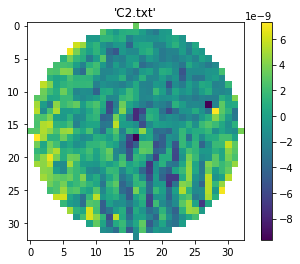

In [121]:
i = 3
N = 20
pvs = []
rmss = []
for t in range(N):
    zcropped[i].crop(zmaps[i].heights.shape[0]//2 - t)
    zcropped[i].rotateflat()
    pvs.append(zcropped[i].peakvalley)
    rmss.append(zcropped[i].rms)

#     print(zcropped[i])
    
plt.imshow(zcropped[i].heights)
plt.title("{}".format(repr(zcropped[i].filename)))
plt.colorbar()
plt.show()

In [122]:
[[pvs[i]*1e9,rmss[i]*1e9] for i in range(N)]

[[150.88004026692258, 40.003271606840514],
 [64.6495725612073, 14.922093852427487],
 [52.821450868775266, 10.597003086849138],
 [39.26671228873137, 8.504158314433779],
 [36.53730949481363, 7.602342616227451],
 [35.163256074035004, 7.050289225883588],
 [31.786044095504305, 5.762333386908211],
 [26.71694850848791, 4.584503844051607],
 [25.49965760406494, 4.40534917404239],
 [25.216437309836987, 4.229967633538891],
 [24.946539107610786, 3.9316376722950133],
 [24.86080086943889, 3.9427786831978886],
 [24.788921587095054, 3.8836196576589397],
 [24.78355115823468, 3.785957371480136],
 [24.737100678381783, 3.3787842946701785],
 [24.71563069684733, 3.3394784725062236],
 [23.09981830876258, 3.7177612031696197],
 [22.142494745338787, 3.534458967575078],
 [17.29268213726122, 2.792225404208385],
 [16.939920282679967, 2.806962710448889]]

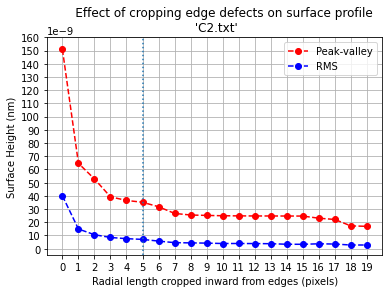

In [123]:
plt.plot(range(N), pvs, "ro--", label="Peak-valley")
plt.plot(range(N), rmss, "bo--", label="RMS")
plt.axvline(5, linestyle="dotted")
plt.yticks(np.arange(0,pvs[0]+10e-9,10e-9))
plt.xticks(range(0,N))
plt.ticklabel_format(axis="y", style="sci", scilimits=(-9,-9))
plt.title("     Effect of cropping edge defects on surface profile\n {0}".format(repr(zcropped[i].filename)))
plt.xlabel("Radial length cropped inward from edges (pixels)")
plt.ylabel("Surface Height (nm)")
plt.legend()
plt.grid()
# plt.savefig("cropDependenceC2.png")
plt.show()

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


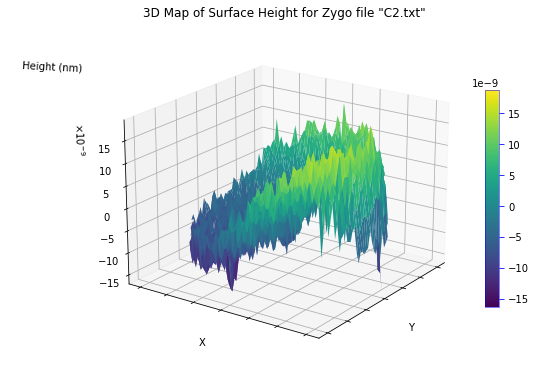

In [124]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
zcropped[i].crop(zmaps[i].heights.shape[0]//2 - 5)
zcropped[i].rotateflat()

x,y = np.indices(zcropped[i].heights.shape)
peak,valley = zcropped[i].peak,zcropped[i].valley
ax.set_zlim(valley,peak)
current_cmap = copy.copy(cm.get_cmap("viridis"))

p = ax.plot_surface(x,y, zcropped[i].heights, vmin=valley, vmax=peak, cmap=current_cmap, ccount=10000, rcount=10000)

cb = plt.colorbar(p, pad=0.05, shrink=0.5, aspect=15)#, ticks=[valley, 0, peak])
cb.ax.tick_params(color="b", length=5)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-9,-9))
cb.outline.set_edgecolor("b")
cb.outline.set_linewidth(0.5)
ax.set_title("3D Map of Surface Height for Zygo file \"{}\"".format(zmaps[i].filename), pad=-1000)
plt.ticklabel_format(axis="z", style="sci", scilimits=(-9,-9), useMathText=True)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Y")  # - since matrix i,j are used for axes, spatial x,y should swap
plt.ylabel("X")
ax.set_zlabel("Height (nm)" + "\n"*24)
ax.zaxis._axinfo["label"]["ha"] = "right"
ax.zaxis.set_rotate_label(False)
ax.zaxis.label.set_rotation("-3")
# ax.zaxis.set_label_coords(0,0)

ax.view_init(elev=20, azim=35)
# plt.savefig("3Dplot_C2.png")
plt.show()

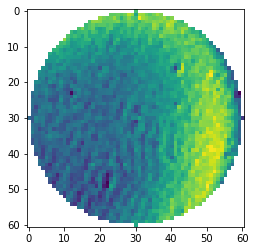

In [125]:
plt.imshow(zcropped[i].heights)
plt.show()

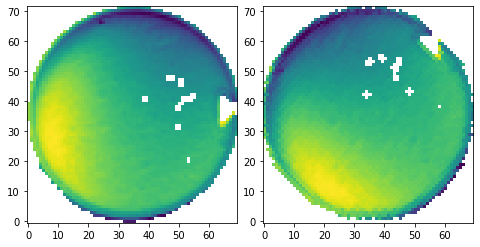

In [188]:
j = 0
fig, ax = plt.subplots(1,2, sharey="col", figsize=(8,5))

ax[0].imshow(zmaps[j].heights[::-1], origin="lower")
ax[1].imshow(scipy.ndimage.rotate(zmaps[j].heights, 45, order=0, reshape=False, mode="constant", cval=np.nan)[::-1], origin="lower")

plt.subplots_adjust(hspace=0, wspace=0.12)
plt.savefig("zrotations.png")
plt.show()